In [3]:
import numpy as np
import pandas as pd
import re,os
import matplotlib.pyplot as plt
import seaborn as sns

### Pre-processing TCGA-LIHC survival information

In [125]:
clinical_file = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/sample_info/tmp.txt",sep='\t',index_col=0)
clinical_file = clinical_file.iloc[1:,:]
clinical_file.index = clinical_file['patient_id']
survival_col = ['vital_status','days_to_initial_pathologic_diagnosis','days_to_death','days_to_last_followup','pathologic_stage','gender','age_at_initial_pathologic_diagnosis','race','viral_hepatitis_serology']
survival_data = clinical_file.loc[:,survival_col]
survival_data['HBV'] = np.where([re.search('Hepatitis B Surface Antigen',x) for x in survival_data['viral_hepatitis_serology']],'Positive','Negative')

In [126]:
include_idx = survival_data['days_to_initial_pathologic_diagnosis'] == '0'
exclude_patient = list(survival_data.index[~include_idx])
survival_data = survival_data.loc[include_idx,:].copy()
### exclude crterion : both days_to_death & days_to_followup is missing value
#change days_to_death/days_to_last_followup to numeric
def numeric_survival(r) :
    if 'Not' not in r['days_to_death'] :
        return int(r['days_to_death'])
    else :
        return int(r['days_to_last_followup'])

survival_data['Survival_day'] = survival_data.apply(numeric_survival,axis=1)
# Status == True means patient dead in study period,else is False
survival_data['Status'] = np.where(survival_data['vital_status'] == 'Dead','Dead','Alive')
include_idx = np.where(survival_data['Survival_day'] > 0,True,False)
survival_data = survival_data.loc[include_idx,:].copy()


In [127]:
# Merge tumor stage subclass in main stage
stage_d = {'[Discrepancy]': 'Not Available',
              '[Not Available]': 'Not Available',
              'Stage I': 'Stage I',
              'Stage II': 'Stage II',
              'Stage IIIA': 'Stage III',
              'Stage IIIB': 'Stage III',
              'Stage IIIC': 'Stage III',
              'Stage IV': 'Stage IV',
              'Stage III': 'Stage III',
              'Stage IVB': 'Stage IV',
              'Stage IVA': 'Stage IV'}
survival_data['Stage'] = survival_data['pathologic_stage'].map(stage_d)

In [92]:
#5 years survival
survival_value = survival_data.loc[:,['Status','Survival_day']]
day_5_years = (365 * 5 + 1)
for idx in range(survival_value.shape[0]) :
    # live more than 5 years 
    if survival_value['Status'][idx] == 'Alive' and survival_value['Survival_day'][idx] > day_5_years :
        survival_value['Survival_day'][idx] = day_5_years
    # live more than 5 years but dead after 5 years
    elif survival_value['Status'][idx] == 'Dead' and survival_value['Survival_day'][idx] > day_5_years :
        survival_value['Status'][idx] = 'Alive'

survival_input = pd.concat([survival_value,survival_data.loc[:,['Stage','gender','age_at_initial_pathologic_diagnosis','race','HBV']]],axis=1)
survival_input.rename(columns={'gender' : 'Gender','age_at_initial_pathologic_diagnosis':'Age'},inplace=True)
survival_input.to_csv('/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/tcga_lihc_survival_info.txt',sep='\t')

/tmp/ipykernel_1791724/1289045465.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_value['Status'][idx] = 'Alive'
/tmp/ipykernel_1791724/1289045465.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_value['Survival_day'][idx] = day_5_years


### Merge gene expression and survival information

* processing of merge gene expression and survival information
1. Standardize gene expression. (Patient tumor sample only)
2. Read functional module information.
3. Extract module gene expression.
4. Convert gene name from ens accession number to gene symbol.
5. Merge survival infor and gene expression.

In [137]:
from sklearn.preprocessing import StandardScaler
import pickle

In [138]:
def edge2node(edge_context) :
    '''
    edge_list : str, like 'ENSG00000115415 ENSG00000138496_ENSG00000115415 ENSG00000168961_ENSG00000115415, underline as seperator
    '''
    edge_l = edge_context.split('_')
    node_l = set(list(map(lambda x : x.split(' ')[0],edge_l)) + list(map(lambda x : x.split(' ')[1],edge_l)))
    return list(node_l)

In [139]:
exp_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/LIHC_coding_gene_fpkm.txt",sep='\t',index_col=0)
sample_idx = [bool(re.search('_n',x)) == False for x in exp_df.columns]
exp_m = exp_df.loc[:,sample_idx]
del exp_df
samples = set(survival_input.index).intersection(exp_m.columns)
#standardization
scaler = StandardScaler()
std_x = scaler.fit_transform(exp_m.T.to_numpy())
std_m = pd.DataFrame(std_x,index=exp_m.columns,columns=exp_m.index)

In [100]:
with open("/home/bruce1996/data/LIHC_anomaly_detection/data/coding_gene_info/ensembl2hgnc.pkl",'rb') as f :
    ens2hgsc = pickle.load(f)
f.close()

In [141]:
ppi = 'GRN'
output_path = "/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/5year_survival_input_with_hbv/zscore/lihc_%s_hbv_only_35/" % ppi
module_excel = pd.ExcelFile("/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/Summary_table_of_%s_FunModu.xlsx" % ppi)
module_summary = pd.read_excel(module_excel,sheet_name='hbv_only_35')
for idx in range(module_summary.shape[0]) :
    go = module_summary['GOID'][idx]
    des = module_summary['Description'][idx].replace(' ','-')
    gene_list = edge2node(module_summary['Edges'][idx])
    module_m = std_m.loc[samples,gene_list]
    module_m.rename(columns=ens2hgsc,inplace=True)
    survival_m = pd.concat([survival_input.loc[samples,:],module_m],axis=1)
    if os.path.exists(output_path) == False :
        os.mkdir(output_path)
    survival_m.to_csv(output_path + go + '_' + des + '.txt',sep='\t')

In [142]:
# separate survival data into HBV / non-HBV group
output_path = "/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/tcga_lihc_survival_input/zscore/"
metadata = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/sample_info/sample_info_df.txt",sep='\t',index_col=0)
metadata.index = metadata['Sample']
for ppi in ['PIN','GRN'] :
    survival_input_path = "/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/5year_survival_input_with_hbv/zscore/lihc_%s_hbv_only_35/" % ppi
    file_list = os.listdir(survival_input_path)
    for file in file_list :
        df = pd.read_csv(survival_input_path + file,sep='\t',index_col=0)
        hbv_idx = metadata.index[np.where(metadata['HBV'] == 'Positive',True,False)]
        hbv_samples = list(set(hbv_idx).intersection(df.index))
        non_hbv_samples = list(set(df.index) - set(hbv_samples))
        if os.path.exists(output_path + 'HBV/%s/' % ppi) == False :
            os.mkdir(output_path + 'HBV/%s/' % ppi)
        if os.path.exists(output_path + 'non-HBV/%s/' % ppi) == False :
            os.mkdir(output_path + 'non-HBV/%s/' % ppi)
        df.loc[hbv_samples,:].to_csv(output_path + 'HBV/%s/%s' % (ppi,file),sep='\t')
        df.loc[non_hbv_samples,:].to_csv(output_path + 'non-HBV/%s/%s' % (ppi,file),sep='\t')

### MHC class expression in TCGA-LIHC HBV group

In [1]:
from statannot import add_stat_annotation

In [4]:
input_path = "/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/tcga_candidate_module/"
module_name = "GO:0019885_antigen-processing-and-presentation-of-endogenous-peptide-antigen-via-MHC-class-I.txt"
survival_matrix = pd.read_csv(input_path + module_name,sep='\t',index_col=0)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HLA.A_Low risk v.s. HLA.A_High risk: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.182e-01 U_stat=1.038e+03
B2M_Low risk v.s. B2M_High risk: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.462e+03
HLA.B_Low risk v.s. HLA.B_High risk: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.267e+03
HLA.C_Low risk v.s. HLA.C_High risk: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.957e-03 U_stat=8.370e+02
TAP1_Low risk v.s. TAP1_High risk: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.016e-01 U_stat=1.071e+03
TAP2_Low risk v.s. TAP2_High risk: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.237e-08 U_stat=4.800e+02


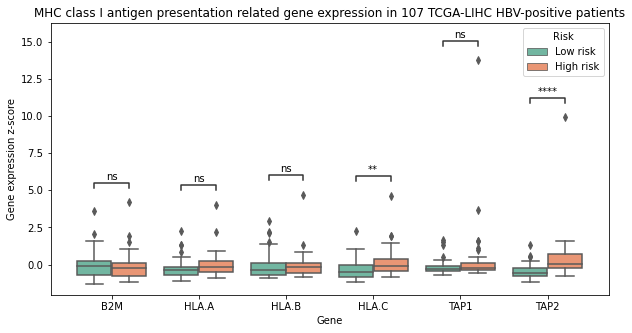

In [7]:
plot_df = survival_matrix.iloc[:,7:].melt(id_vars='risk')
plot_df.columns = ["Risk","Gene","Value"]
plot_df.sort_values(by='Gene',inplace=True)
x_order = list(plot_df['Gene'].unique())

plt.figure(figsize=(10,5))
ax = sns.boxplot(data=plot_df,x='Gene',y='Value',hue='Risk',palette='Set2',order=x_order,hue_order=['Low risk','High risk'],showfliers=True)
plt.ylabel("Gene expression z-score")
box_pairs =  [((gene, 'Low risk'), (gene, 'High risk')) for gene in plot_df['Gene'].unique()]
add_stat_annotation(ax, data=plot_df, x='Gene', y='Value',hue='Risk', order=x_order,
                    box_pairs=box_pairs,test='Mann-Whitney',verbose=1)
plt.title("MHC class I antigen presentation related gene expression in %d TCGA-LIHC HBV-positive patients" % survival_matrix.shape[0])
plt.savefig(input_path + module_name.replace('txt','png'),dpi=300,bbox_inches='tight')

In [8]:
input_path = "/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/5year_survival_input_with_hbv/zscore/lihc_PIN_hbv_only_35/"
module_name = "GO:0019885_antigen-processing-and-presentation-of-endogenous-peptide-antigen-via-MHC-class-I.txt"
survival_matrix = pd.read_csv(input_path + module_name,sep='\t',index_col=0)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HLA-A_Negative v.s. HLA-A_Positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.791e-02 U_stat=1.350e+04
B2M_Negative v.s. B2M_Positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.252e+04
HLA-B_Negative v.s. HLA-B_Positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.214e+04
HLA-C_Negative v.s. HLA-C_Positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.100e-01 U_stat=1.273e+04
TAP1_Negative v.s. TAP1_Positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.231e+04
TAP2_Negative v.s. TAP2_Positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.254e+04


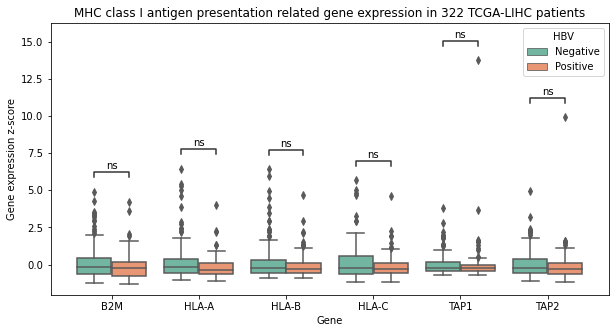

In [14]:
plot_df = survival_matrix.iloc[:,6:].melt(id_vars='HBV')
plot_df.columns = ["HBV","Gene","Value"]
plot_df.sort_values(by='Gene',inplace=True)
x_order = list(plot_df['Gene'].unique())

plt.figure(figsize=(10,5))
ax = sns.boxplot(data=plot_df,x='Gene',y='Value',hue='HBV',palette='Set2',order=x_order,hue_order=['Negative','Positive'],showfliers=True)
plt.ylabel("Gene expression z-score")
box_pairs =  [((gene, 'Negative'), (gene, 'Positive')) for gene in plot_df['Gene'].unique()]
add_stat_annotation(ax, data=plot_df, x='Gene', y='Value',hue='HBV', order=x_order,
                    box_pairs=box_pairs,test='Mann-Whitney',verbose=1)
plt.title("MHC class I antigen presentation related gene expression in %d TCGA-LIHC patients" % survival_matrix.shape[0])
output_path = "/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/tcga_candidate_module/"
plt.savefig(output_path + module_name.replace('.txt','-between-hbv.png'),dpi=300,bbox_inches='tight')